<a href="https://colab.research.google.com/github/davidyr23/Fisicacomputacional1/blob/master/Evaluaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Parte 1: Construcción de una Serie de Tiempo**



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Bibliotecas para el análisis de series de tiempo y modelos de pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

#Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
url = "https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_brw_DailyData.txt"

# Nombramos las columnas del df
my_cols = ['site_code', 'year', 'month', 'day', 'hour','minute','second','time_decimal', 'value', 'value_std_dev', 'nvalue', 'latitude','longitude','altitude', 'elevation', 'intake_height', 'qcflag']

# El archivo tiene 151 líneas de encabezado, así que asignamos un dataframe que se salte dichas líneas
df_barrow = pd.read_csv(url, names=my_cols, encoding="cp1251", sep="\s+", header=None, skiprows=151, skipfooter=1, engine="python")

# Se realiza una copia con la que trabajar para no perder el original
df_c=df_barrow.copy()

# Reemplazamos los números de la columna "value" iguales a -999.99 por 'NaN'
str_Nulo = -999.99
df_c = df_c.replace(to_replace=str_Nulo, value='NaN', regex=True)

# Procedemos a convertir los datos a valores numericos para poder trabajar con los datos
columnas = ["value"]
for cols in columnas:
  df_c[cols] = pd.to_numeric(df_c[cols], errors="coerce")


# Asignamos formato de fecha: (El .copy es necesario)
df_c["Fecha"] = pd.to_datetime(df_c["year"].astype(str) + df_c["month"].astype(str).str.zfill(2) + df_c["day"].astype(str).str.zfill(2),format="%Y%m%d").copy()

# Agregamos la columna "Año"
df_c["Año"] = df_c["Fecha"].dt.year

# Eliminamos las siguientes columnas
df_c.drop(["year","month","day","hour","minute","second","time_decimal","site_code","value_std_dev","nvalue","latitude","longitude","altitude","elevation","intake_height","qcflag"], axis=1, inplace=True)

# Verificamos
df_c

,value,Fecha,Año
0,NaN,1973-01-01,1973
1,NaN,1973-01-02,1973
2,NaN,1973-01-03,1973
3,NaN,1973-01-04,1973
4,NaN,1973-01-05,1973
...,...,...,...
17160,416.98,2019-12-26,2019
17161,416.86,2019-12-27,2019
17162,416.83,2019-12-28,2019
17163,417.01,2019-12-29,2019


In [ ]:
# checkpoint
ts_test=df_c.copy()

# Se redefine el indice de todo el DataFrame para que sea la fecha en vez de un contador.
ts_test = ts_test.set_index("Fecha")

# Verificación
ts_test

,value,Año
Fecha,,
1973-01-01,NaN,1973
1973-01-02,NaN,1973
1973-01-03,NaN,1973
1973-01-04,NaN,1973
1973-01-05,NaN,1973
...,...,...
2019-12-26,416.98,2019
2019-12-27,416.86,2019
2019-12-28,416.83,2019


In [ ]:
# La base de datos de Barrow comienza en 1973 y finaliza en 2019, precisamente este rango de datos es de interes pues queremos analizar los ultimos 30 años.
# Dado lo anterior el rango de datos será: 1980 - 2019

# Tomamos los datos del año 1980 a 2019
ts_test = ts_test[(ts_test["Año"] >= 1980) & (ts_test["Año"] <= 2019)]

# Eliminamos la columna "Año"
ts_test.drop(["Año"], axis=1, inplace=True)
ts_test.ffill(axis = 0, inplace=True)
ts_test

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,value
Fecha,
1980-01-01,341.38
1980-01-02,341.65
1980-01-03,341.65
1980-01-04,341.65
1980-01-05,341.65
...,...
2019-12-26,416.98
2019-12-27,416.86
2019-12-28,416.83


## **Parte 2: Análisis de la Serie de Tiempo**

In [ ]:
# Función para probar la estacionaridad de una serie de tiempo:
   
def test_stationarity(df_ts):
    
# Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() #std Desviación estándar
    
# Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

# Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
# Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

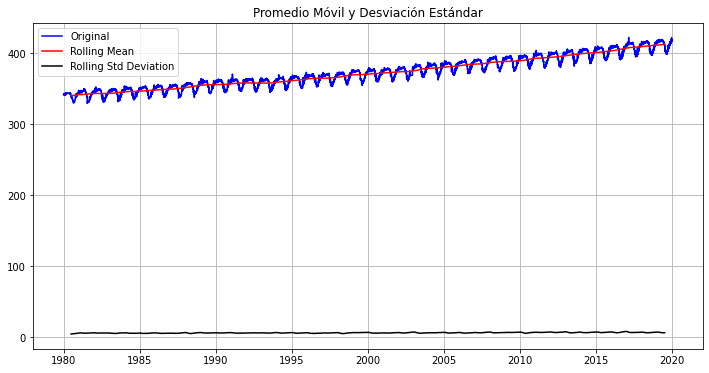

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                    -3.236940
p-value                            0.017944
#Lags Used                        37.000000
Number of Observations Used    14571.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861738
Critical Value (10%)              -2.566876
dtype: float64


In [ ]:
# Probamos la estacionaridad en la serie de tiempo "ts_test"
ts_test1 = ts_test["value"].copy()
test_stationarity(ts_test1)

Como p=0.017944 (menor a 0.05), podemos decir que la serie de tiempo es estacionaria.

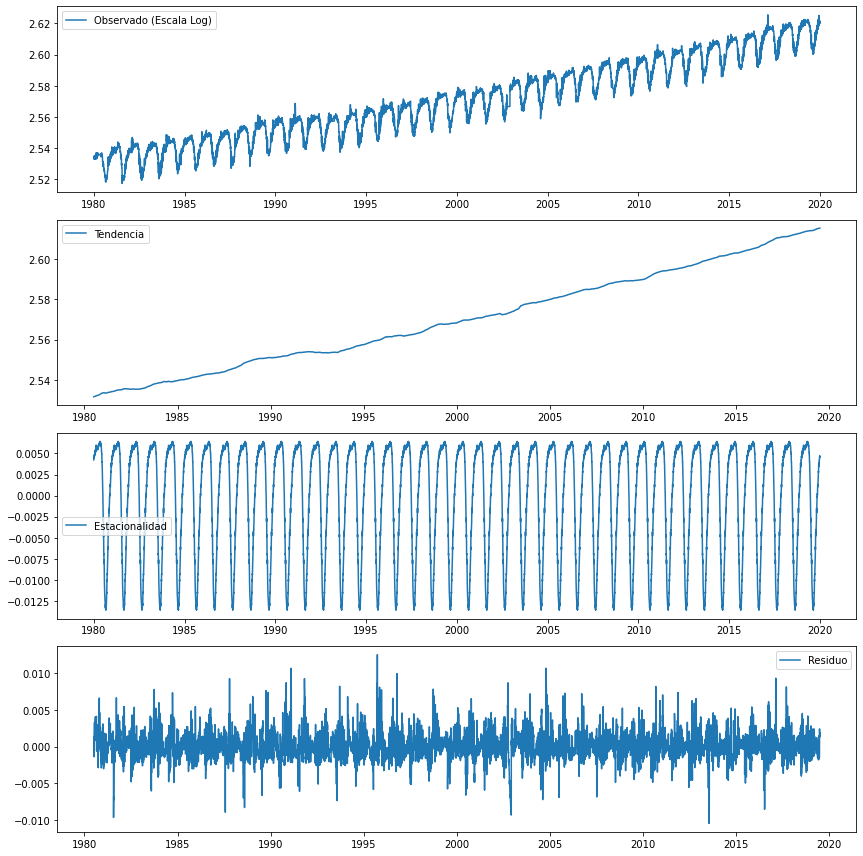

In [ ]:
# Método de descomposición usando la biblioteca statsmodels.tsa

ts_test_log = np.log10(ts_test)

pmov = ts_test_log.rolling(365, center=True).mean()

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

# Serie de tendencia
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

# Serie de estacionalidad
plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

# Serie de residuo
plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();


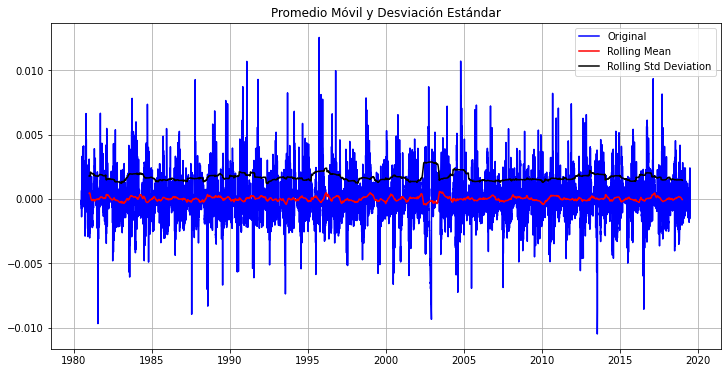

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -22.745264
p-value                            0.000000
#Lags Used                        12.000000
Number of Observations Used    14232.000000
Critical Value (1%)               -3.430810
Critical Value (5%)               -2.861743
Critical Value (10%)              -2.566878
dtype: float64


In [ ]:
# Quitamos los valores vacíos en la componente de residuo y probamos la estacionaridad de la componente de residuo

residue.dropna(inplace=True)
test_stationarity(residue['value'])

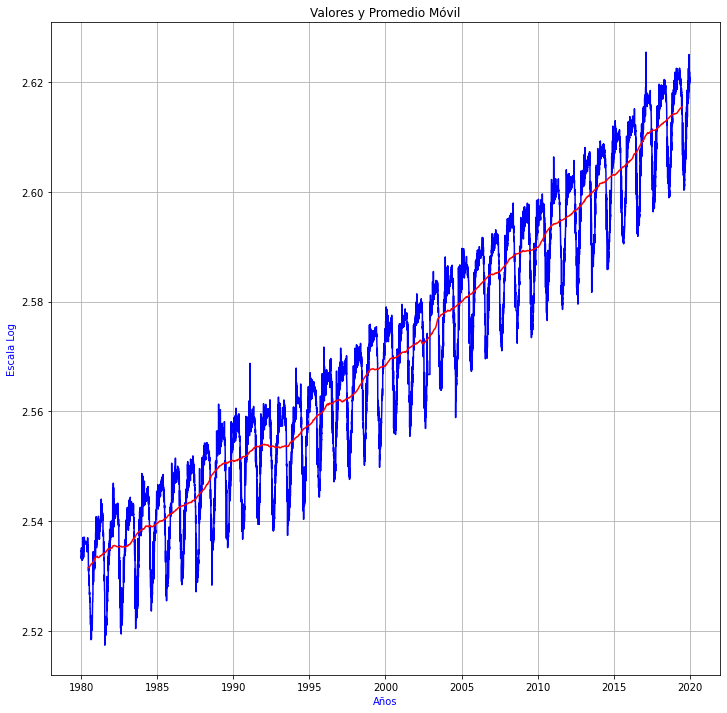

In [ ]:
# Graficamos la serie logarítmica junto con el promedio móvil para visualizar
plt.plot(ts_test_log, color = 'b', label = 'ts_test_log')
plt.plot(pmov, color = 'r', label = 'Promedio móvil')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

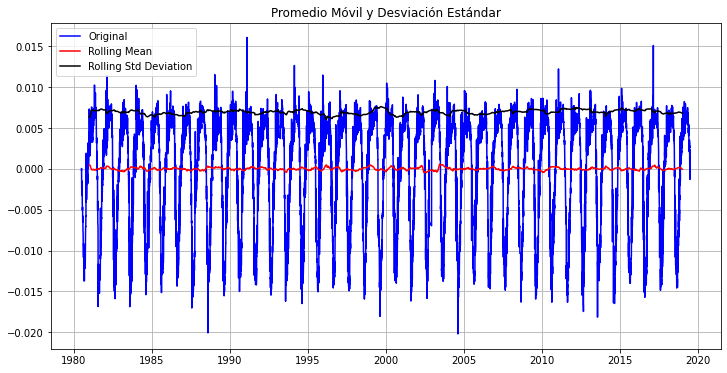

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.483177e+01
p-value                        1.894479e-27
#Lags Used                     4.200000e+01
Number of Observations Used    1.420200e+04
Critical Value (1%)           -3.430811e+00
Critical Value (5%)           -2.861744e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [ ]:
# Creamos el dataframe de la diferencia entre la serie logarítmica y el promedio móvil
ts_test_log_diff = ts_test_log - pmov
# Quitamos valores nulos
ts_test_log_diff.dropna(inplace=True)
# Revisamos la estacionaridad de este nuevo dataframe
test_stationarity(ts_test_log_diff['value'])

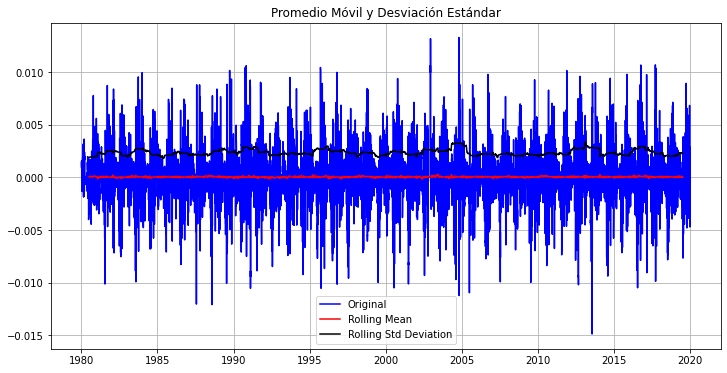

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.141389e+01
p-value                        7.139830e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.455900e+04
Critical Value (1%)           -3.430799e+00
Critical Value (5%)           -2.861739e+00
Critical Value (10%)          -2.566876e+00
dtype: float64


In [ ]:
# Creamos otro dataframe similar pero con la función .shift con prediodo de 7 días
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
# Quitamos valores nulos
ts_test_log_diff.dropna(inplace=True)
# Revisamos la estacionaridad de este nuevo dataframe
test_stationarity(ts_test_log_diff['value'])

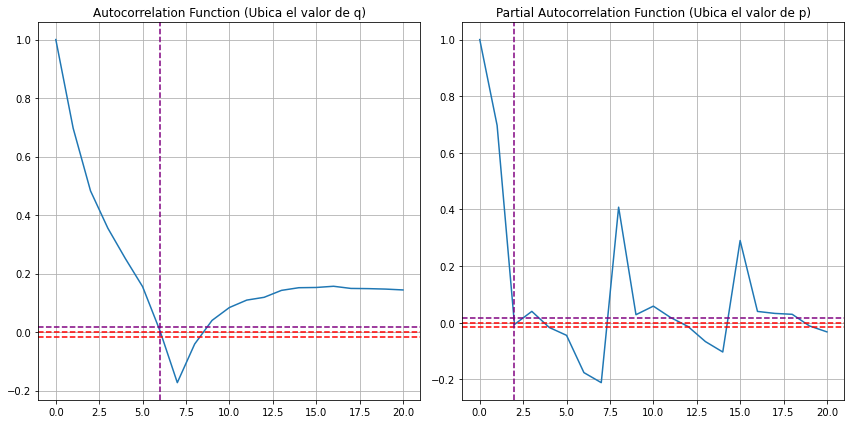

In [ ]:
lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='red')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='red')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='purple')
#Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=6, linestyle='--', color='purple')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='red')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='red')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='purple')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='purple')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14608
Model:                 ARIMA(2, 1, 0)   Log Likelihood               76726.319
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -153444.637
Time:                        05:24:01   BIC                        -153414.280
Sample:                    01-02-1980   HQIC                       -153434.552
                         - 12-30-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.975e-06    7.8e-06      0.766      0.444   -9.32e-06    2.13e-05
ar.L1.D.value    -0.1744      0.008    -21.386      0.000      -0.190      -0.158
ar.L2.D.value    -0.1687      0.008    -

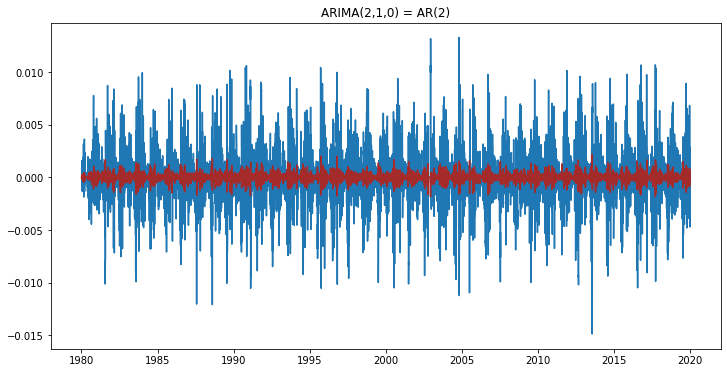

In [ ]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14608
Model:                 ARIMA(0, 1, 6)   Log Likelihood               76857.826
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -153699.652
Time:                        05:30:47   BIC                        -153638.937
Sample:                    01-02-1980   HQIC                       -153679.481
                         - 12-30-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           5.96e-06   5.87e-06      1.015      0.310   -5.54e-06    1.75e-05
ma.L1.D.value    -0.2029      0.008    -24.520      0.000      -0.219      -0.187
ma.L2.D.value    -0.1659      0.008    -

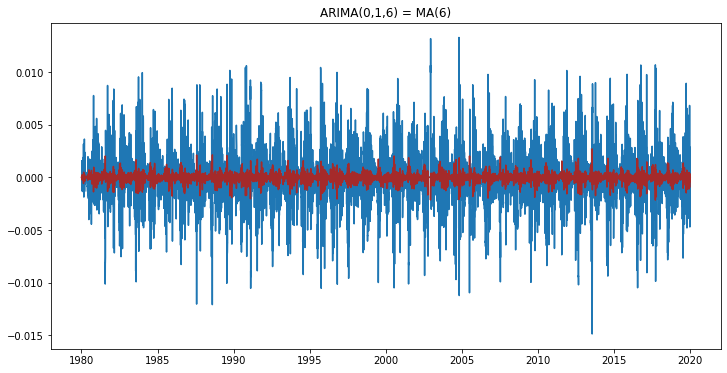

In [ ]:
# Modelo MA(q): (p,d,q) = (0,1,6) 
model = ARIMA(ts_test_log, order=(0,1,6), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,6) = MA(6)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14608
Model:                 ARIMA(2, 1, 6)   Log Likelihood               76967.506
Method:                       css-mle   S.D. of innovations              0.001
Date:                Thu, 25 Feb 2021   AIC                        -153915.011
Time:                        05:32:00   BIC                        -153839.118
Sample:                    01-02-1980   HQIC                       -153889.798
                         - 12-30-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.069e-06   1.17e-05      0.518      0.604   -1.69e-05     2.9e-05
ar.L1.D.value     0.1182        nan        nan        nan         nan         nan
ar.L2.D.value     0.8383        nan     

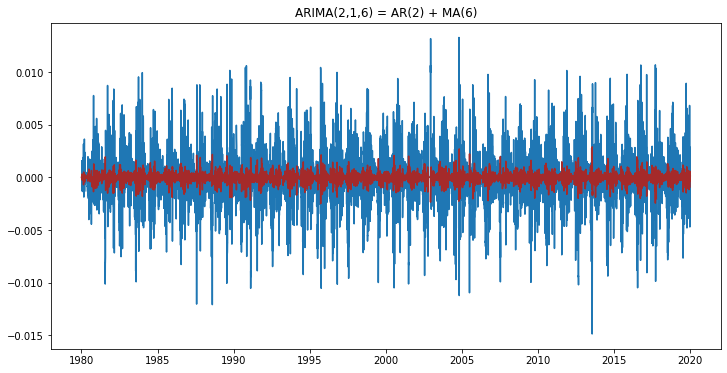

In [ ]:
# Modelo ARIMA(p): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test_log, order=(2,1,6), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,6) = AR(2) + MA(6)')
print(results_ARIMA.summary())

In [ ]:
# Creamos la serie de tiempo con los datos de las prediccións de ARIMA
ARIMA_ts = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(ARIMA_ts)

Fecha
1980-01-02    0.000006
1980-01-03   -0.000042
1980-01-04   -0.000050
1980-01-05   -0.000030
1980-01-06   -0.000027
                ...   
2019-12-26   -0.000278
2019-12-27    0.000035
2019-12-28    0.000208
2019-12-29    0.000121
2019-12-30    0.000170
Length: 14608, dtype: float64


In [ ]:
# Sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
ARIMA_log = pd.Series(ts_test_log['value'], index = ts_test_log['value'].index)
ARIMA_log = ARIMA_log.add(ARIMA_ts)
print(ARIMA_log.head())
print(ARIMA_log.tail())

Fecha
1980-01-01         NaN
1980-01-02    2.533587
1980-01-03    2.533539
1980-01-04    2.533532
1980-01-05    2.533552
dtype: float64
Fecha
2019-12-26    2.619837
2019-12-27    2.620025
2019-12-28    2.620167
2019-12-29    2.620268
2019-12-30    2.620983
dtype: float64


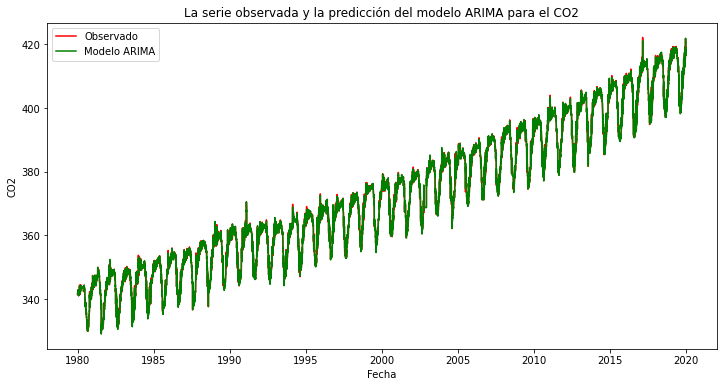

In [ ]:
# Regresamos a la escala original
ARIMA_ts = 10**(ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA
plt.rcParams["figure.figsize"] = (12,6)
plt.plot(ts_test, label='Observado', color = 'r');
plt.plot(ARIMA_ts, label='Modelo ARIMA', color = 'g');
plt.xlabel('Fecha')
plt.ylabel('CO2')
plt.title('La serie observada y la predicción del modelo ARIMA para el CO2')
plt.legend(loc='best');

In [ ]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((ARIMA_ts - ts_test['value'])**2))
print('RMSE:', RMSE)

RMSE: 0.3364160535634778


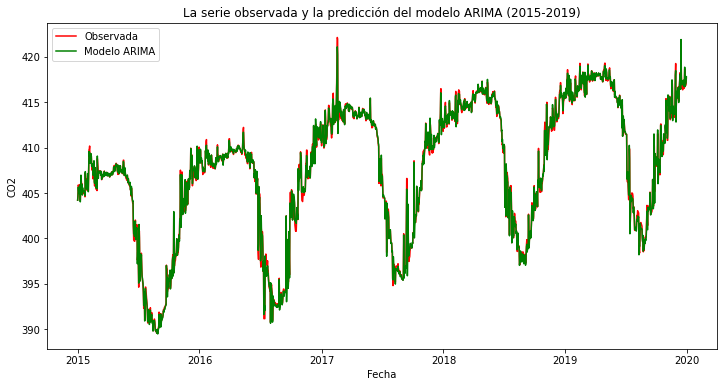

In [ ]:
#Graficando los últimos 5 años de las series 
ts_test_last = ts_test.tail(1825)
ARIMA_ts_last = ARIMA_ts.tail(1825)
plt.plot(ts_test_last, label='Observada', color = 'r');
plt.plot(ARIMA_ts_last, label='Modelo ARIMA', color = 'g');
plt.xlabel('Fecha')
plt.ylabel('CO2')
plt.title('La serie observada y la predicción del modelo ARIMA (2015-2019)')
plt.legend(loc='best');